In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        p[-1, jmax//2:] = p[-2, jmax//2:]

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2.0*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2.0*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )
    
    #apply the velocity boundary condition to the projected velocity data
    imax = len(u)
    jmax = np.size(u)//imax
    u[0,:] = u[1,:]
    u[-1,:-(jmax-jmax//2)] = u[-2,:-(jmax-jmax//2)]

    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    return u, v

In [4]:
def update_concentrations(C, C_old, u, v, D, k, dx,dy,dt, logs = False):
    #update the interior points
    
    C[1:-1,1:-1] = C_old[1:-1,1:-1] + dt*(-k*C_old[1:-1,1:-1]
                                +D*(np.diff(C_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                + np.diff(C_old[1:-1, :], n=2, axis=1)/(dy**2))
                                -u[1:-1, 1:-1] *
                                    np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] < 0],
                                    [np.diff(C_old[:-1, 1:-1], n=1, axis=0)/dx,
                                    np.diff(C_old[1:, 1:-1], n=1, axis=0)/dx]) -
                                 v[1:-1, 1:-1] *
                                    np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] < 0],
                                      [np.diff(C_old[1:-1, :-1], n=1, axis=1)/dy,
                                       np.diff(C_old[1:-1, 1:], n=1, axis=1)/dy]))
    
    #solve the boundary conditions
    C[-1,:]=C[-2,:]
    C[:,0]=C[:,1]
    C[:,-1]=C[:,-2]
    
    return C

In [5]:
def solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    C_old = C.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    while t < t_end:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
            dt = min(courant*(min(dx,dy)**2)/(D*2.0), dt)
        else:
            dt = min(courant*(min(dx,dy)**2)/(D*2.0), dt_min)
        t += dt
        
        if logs and time_it%outint == 0:
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        C = update_concentrations(C, C_old, u, v, D, k, dx,dy,dt, logs)
        
        if logs and time_it%outint == 0:
            imax = len(p)
            jmax = np.size(p)//imax
    
            C_out = np.average(u[-1,:jmax//2]*C[-1,:jmax//2])/np.average(u[-1,:jmax//2])

            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
            print('Average outlet concentration = ', C_out)
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
        temp = C_old
        C_old = C
        C = temp
        
    return u, v, p, C

In [23]:
# physical parameters
rho = 1000
nu = 1e-6
D = 1.e-6
k = 0.25

# define spatial mesh
# Size of rectangular domain
Lx = 0.05
Ly = 0.025

P_max = 0.5

C_0 = 1.0

# Reduced grid resolution
Nx = 51
Ny = 25

dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y

# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)
C = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax
p[0, :] = P_max
p[-1, :-(jmax-jmax//2)-1] = 0.0

C[0, :] = C_0

#set a Courant number and use dynamic time step
courant = 0.1
dt_min = 1.e-3

t_end = 20

import time
start = time.time()
u, v, p, C = solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 1000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 1.00000000
pressure solve iterations =   29
norm(u) = 0.25676593, norm(v) = 0.06518855
Courant number: 0.01681035
Average outlet concentration =  3.0392071506368165e-30

Time = 2.00000000
pressure solve iterations =   13
norm(u) = 0.37957596, norm(v) = 0.09611671
Courant number: 0.02510594
Average outlet concentration =  4.2560243779271414e-11

Time = 3.00000000
pressure solve iterations =    4
norm(u) = 0.42627511, norm(v) = 0.10464928
Courant number: 0.02799123
Average outlet concentration =  0.0002793619750208205

Time = 4.00000000
pressure solve iterations =    1
norm(u) = 0.44735220, norm(v) = 0.10613145
Courant number: 0.02908461
Average outlet concentration =  0.0686256534847995

Time = 5.00000000
pressure solve iterations =    1
norm(u) = 0.46007715, norm(v) = 0.10586638
Courant number: 0.02966435
Average outlet concentration =  0.29093007498910467

Time = 6.00000000
pressure solve iterations =    1
norm(u) = 0.46930496, norm(v) = 0.10525945
Courant number: 0.03006804
A

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Physical parameters and parameter ranges
rho = 1000  # Fluid density
nu_values = [1e-6, 2e-6]  # Kinematic viscosity values (m^2/s)
D_values = [1e-6, 2e-6]  # Diffusivity values (m^2/s)
k_values = [0.1, 0.25, 0.5]  # Reaction rate values (1/s)
P_max_values = [0.25, 0.5, 1.0]  # Pressure drop values (Pa)

# Define spatial mesh
Lx = 0.05  # Reactor length (m)
Ly = 0.025  # Reactor height (m)
Nx = 51  # Grid points in x-direction
Ny = 25  # Grid points in y-direction
dx = Lx / (Nx - 1)  # Grid spacing in x
dy = Ly / (Ny - 1)  # Grid spacing in y
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx * X
Y = dy * Y

# Simulation time and numerical settings
courant = 0.1  # Courant number
dt_min = 1.e-3  # Minimum timestep
t_end = 20  # End time for the simulation

# Results storage
results = []

# Solve Navier-Stokes and advection-diffusion-reaction equation
def solve_NS(u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000):
    # Placeholder function for simulation logic
    # This is where your actual solve_NS implementation goes
    return u, v, p, C

# Simulation loop
for i, (nu, D, k, P_max) in enumerate([(nu, D, k, P_max) for nu in nu_values for D in D_values for k in k_values for P_max in P_max_values]):
    # Initialize variables
    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    C = np.zeros_like(X)

    # Apply boundary conditions
    u[:, -1] = 0
    u[:, 0] = 0
    u[0, :] = 0
    u[-1, :] = 0
    v[:, -1] = 0
    v[:, 0] = 0
    v[0, :] = 0
    v[-1, :] = 0
    imax = len(p)
    jmax = np.size(p) // imax
    p[0, :] = P_max
    p[-1, :-(jmax - jmax // 2) - 1] = 0.0
    C[0, :] = 1.0  # Inlet concentration

    # Solve Navier-Stokes and concentration
    print(f"Running simulation {i + 1} for nu={nu}, D={D}, k={k}, P_max={P_max}")
    u, v, p, C = solve_NS(
        u, v, C, p, rho, nu, D, k, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs=False, outint=1000
    )

    # Set up combined figure
    fig = plt.figure(figsize=(21, 14))

    # Subplot 1: Pressure and velocity vectors
    ax1 = fig.add_subplot(231)
    cont = ax1.contourf(X, Y, p, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax1)
    ax1.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
    ax1.set_xlim(-0.005, 0.055)
    ax1.set_ylim(-0.005, 0.0255)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$y$', fontsize=16)
    ax1.set_title('Pressure and Velocity Vectors', fontsize=16)

    # Subplot 2: Speed
    ax2 = fig.add_subplot(232)
    speed = np.sqrt(u**2 + v**2)
    cont = ax2.contourf(X, Y, speed, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax2)
    ax2.set_xlim(-0.005, 0.055)
    ax2.set_ylim(-0.005, 0.0255)
    ax2.set_xlabel('$x$', fontsize=16)
    ax2.set_ylabel('$y$', fontsize=16)
    ax2.set_title('Speed Distribution', fontsize=16)

    # Subplot 3: Concentration profile
    ax3 = fig.add_subplot(233)
    cont = ax3.contourf(X, Y, C, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax3)
    ax3.set_xlim(-0.005, 0.055)
    ax3.set_ylim(-0.005, 0.0255)
    ax3.set_xlabel('$x$', fontsize=16)
    ax3.set_ylabel('$y$', fontsize=16)
    ax3.set_title('Concentration Profile', fontsize=16)

    # Add a title to the figure summarizing the parameters
    fig.suptitle(f'Simulation {i + 1}: nu={nu:.1e}, D={D:.1e}, k={k:.2f}, P_max={P_max:.2f}', fontsize=18)

    # Save the plot to a file
    plt.savefig(f'simulation_{i + 1}_plot.png', dpi=300)
    plt.close(fig)  # Close the figure to free up memory

Running simulation 1 for nu=1e-06, D=1e-06, k=0.1, P_max=0.25
Running simulation 2 for nu=1e-06, D=1e-06, k=0.1, P_max=0.5
Running simulation 3 for nu=1e-06, D=1e-06, k=0.1, P_max=1.0
Running simulation 4 for nu=1e-06, D=1e-06, k=0.25, P_max=0.25
Running simulation 5 for nu=1e-06, D=1e-06, k=0.25, P_max=0.5
Running simulation 6 for nu=1e-06, D=1e-06, k=0.25, P_max=1.0
Running simulation 7 for nu=1e-06, D=1e-06, k=0.5, P_max=0.25
Running simulation 8 for nu=1e-06, D=1e-06, k=0.5, P_max=0.5
Running simulation 9 for nu=1e-06, D=1e-06, k=0.5, P_max=1.0
Running simulation 10 for nu=1e-06, D=2e-06, k=0.1, P_max=0.25
Running simulation 11 for nu=1e-06, D=2e-06, k=0.1, P_max=0.5
Running simulation 12 for nu=1e-06, D=2e-06, k=0.1, P_max=1.0
Running simulation 13 for nu=1e-06, D=2e-06, k=0.25, P_max=0.25
Running simulation 14 for nu=1e-06, D=2e-06, k=0.25, P_max=0.5
Running simulation 15 for nu=1e-06, D=2e-06, k=0.25, P_max=1.0
Running simulation 16 for nu=1e-06, D=2e-06, k=0.5, P_max=0.25
Runni

Text(0.5, 1.0, 'Pressure driven problem - speed')

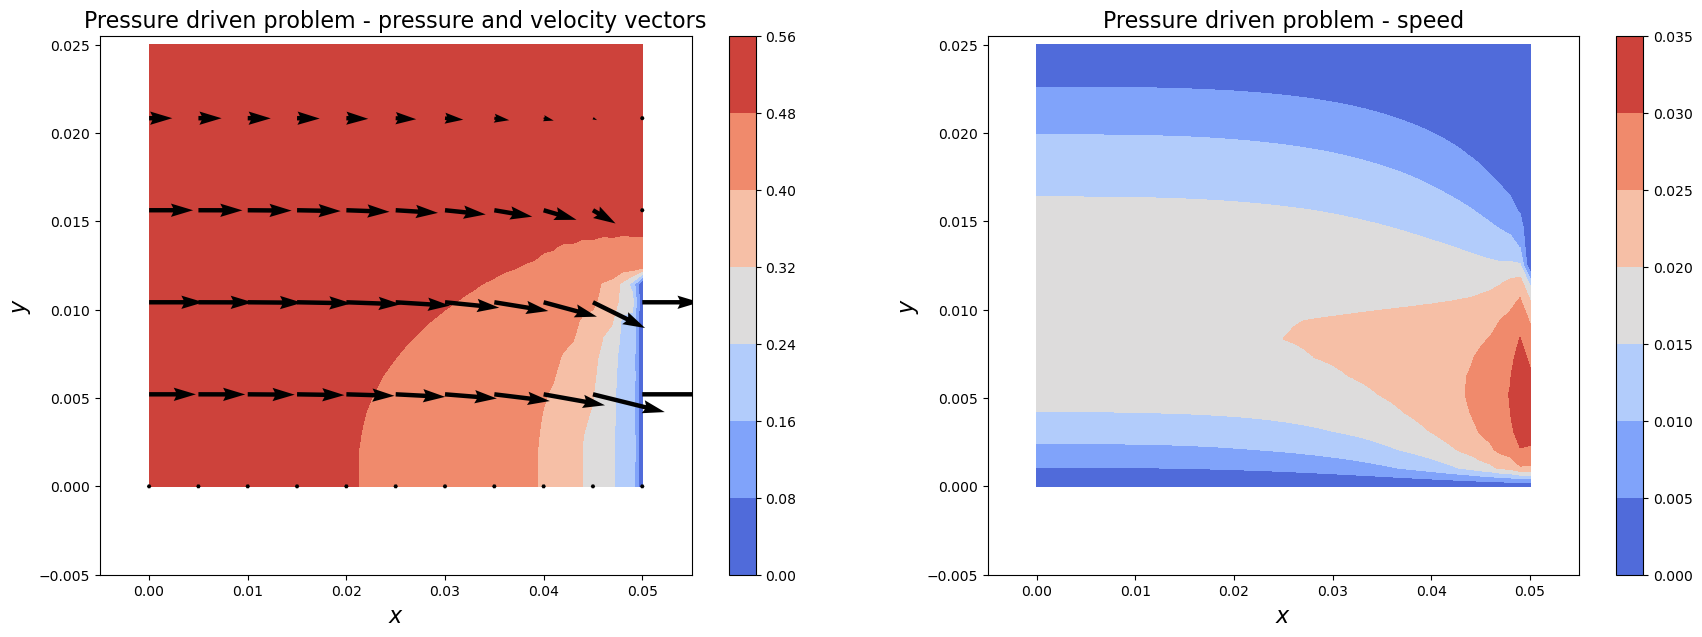

In [24]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.005, 0.055)
ax1.set_ylim(-0.005, 0.0255)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.005, 0.055)
ax1.set_ylim(-0.005, 0.0255)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed', fontsize=16)

Text(0.5, 1.0, 'Concentration Profile')

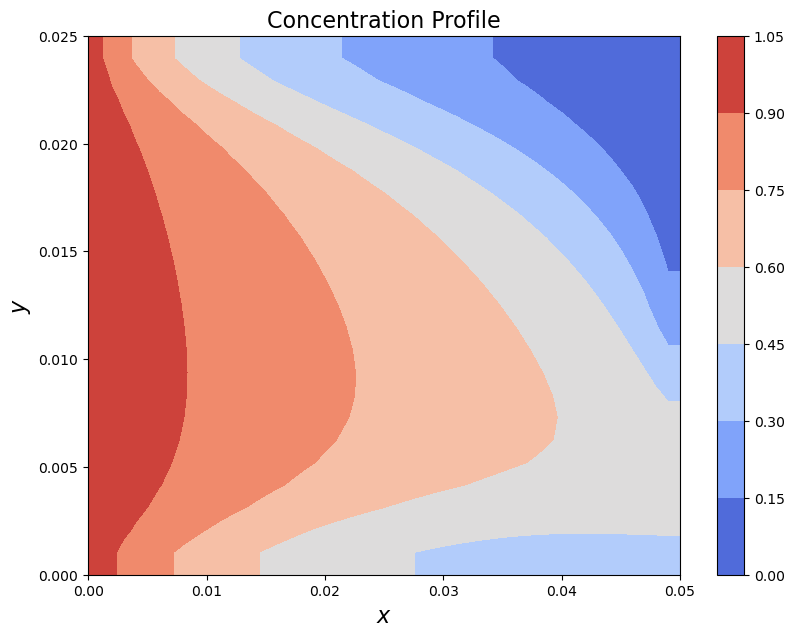

In [25]:
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,C, cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Concentration Profile', fontsize=16)

In [9]:
M_out = 0.0
V_out = 0.0
for j in range(0,jmax//2):
    M_out += u[-1,j] * C[-1,j] * dy
    V_out += u[-1,j] * dy
    
C_out = M_out/V_out

print('Average outlet concentration = ', C_out)

Average outlet concentration =  nan


/var/folders/ct/hydjbthj0vvc7x6h5013m1l40000gn/T/ipykernel_78041/2476011609.py:7: RuntimeWarning: invalid value encountered in scalar divide
  C_out = M_out/V_out


In [10]:
# Function to calculate dimensionless parameters and run simulations
def run_simulation_with_params(Re, Pe, Da):
    """
    Run a single simulation for given Re, Pe, Da, and physical parameters.
    """
    # Calculate physical parameters
    nu = 1e-6  # Kinematic viscosity
    U = Re * nu / Lx  # Characteristic velocity
    D = U * Lx / Pe  # Diffusivity
    k = Da * U / Lx  # Reaction rate
    dp = U * nu / Lx  # Pressure drop

    # Initialize the fields
    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    C = np.zeros_like(X)

    # Apply boundary conditions
    u[:, -1] = 0
    u[:, 0] = 0
    u[0, :] = 0
    u[-1, :] = 0
    v[:, -1] = 0
    v[:, 0] = 0
    v[0, :] = 0
    v[-1, :] = 0
    p[0, :] = dp  # Pressure at the inlet
    p[-1, :-(jmax - jmax // 2) - 1] = 0.0  # Pressure at the outlet
    C[0, :] = C_0  # Inlet concentration

    # Solve the Navier-Stokes and concentration equations
    u, v, p, C = solve_NS(
        u, v, C, p, rho=1000, nu=nu, D=D, k=k,
        courant=0.05, dt_min=1e-3, t_end=100.0, dx=dx, dy=dy, rtol=1e-4, logs=True, outint=5000
    )

    # Calculate average outflow concentration and velocity
    M_out = 0.0
    V_out = 0.0
    for j in range(0, jmax // 2):  # Bottom half of the outlet
        M_out += u[-1, j] * C[-1, j] * dy
        V_out += u[-1, j] * dy

    C_out = M_out / V_out if V_out > 0 else 0.0
    avg_velocity = V_out / (jmax // 2 * dy) if jmax > 0 else 0.0

    print(f"Re={Re}, Pe={Pe}, Da={Da}, Average Outflow Concentration={C_out:.6f}, Average Outflow Velocity={avg_velocity:.6f}")
    return C_out, avg_velocity

# Dimensionless groups
Re_values = [10, 50, 100, 200]  # Reynolds number
Pe_values = [100, 500, 1000, 5000]  # Péclet number
Da_values = [0.1, 1.0, 10.0, 50.0]  # Damköhler number

# Run simulations for all combinations of Re, Pe, and Da
results = []
for Re in Re_values:
    for Pe in Pe_values:
        for Da in Da_values:
            C_out, avg_velocity = run_simulation_with_params(Re, Pe, Da)
            results.append((Re, Pe, Da, C_out, avg_velocity))

KeyboardInterrupt: 

In [11]:
# Function to calculate dimensionless parameters and run simulation
def run_simulation_with_physical_params(nu, D, k, P_max):
    """
    Run a simulation for given physical parameters and calculate dimensionless groups.
    """
    # Reset initial conditions
    u = np.zeros_like(X)
    v = np.zeros_like(X)
    p = np.zeros_like(X)
    C = np.zeros_like(X)
    C[0, :] = C_0  # Inlet concentration boundary condition

    # Apply pressure boundary conditions
    p[0, :] = P_max  # Pressure at the inlet
    p[-1, :-(jmax - jmax // 2) - 1] = 0.0  # Pressure at the outlet

    # Solve the Navier-Stokes and concentration equations
    u, v, p, C = solve_NS(
        u, v, C, p, rho=1000, nu=nu, D=D, k=k,
        courant=0.05, dt_min=1e-3, t_end=100.0, dx=dx, dy=dy, rtol=1e-6, logs=True, outint=1000
    )

    # Calculate average outflow concentration and velocity
    M_out = 0.0
    V_out = 0.0
    for j in range(0, jmax // 2):  # Bottom half of the outlet
        M_out += u[-1, j] * C[-1, j] * dy
        V_out += u[-1, j] * dy

    C_out = M_out / V_out if V_out > 0 else 0.0
    avg_velocity = V_out / (jmax // 2 * dy) if V_out > 0 else 0.0

    # Calculate dimensionless groups
    Re = avg_velocity * Lx / nu  # Reynolds number
    Pe = avg_velocity * Lx / D  # Péclet number
    Da = k * Lx / avg_velocity if avg_velocity > 0 else 0.0  # Damköhler number

    print(f"Physical Parameters: nu={nu:.1e}, D={D:.1e}, k={k:.2f}, P_max={P_max:.2f}")
    print(f"Dimensionless Groups: Re={Re:.2f}, Pe={Pe:.2f}, Da={Da:.2f}")
    print(f"Average Outflow Concentration={C_out:.6f}, Average Outflow Velocity={avg_velocity:.6f}")
    return Re, Pe, Da, C_out, avg_velocity

nu_values = [1e-6]  # Fixed
D_values = [1e-6, 2e-6]  # Diffusivity
k_values = [0.1, 0.5]  # Reaction rate (reduced from 3 to 2 values)
P_max_values = [0.25, 1.0]  # Pressure drop (reduced from 3 to 2 values)

# Run simulations for all combinations of physical parameters
results = []

# Parameters
Nx = 51  # Reduced grid resolution
Ny = 25
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
courant = 0.1  # Increased Courant number
t_end = 50.0  # Reduced final time
outint = 5000  # Reduced logging frequency
rtol = 1e-4  # Looser convergence tolerance

# Simulations
for nu in nu_values:
    for D in D_values:
        for k in k_values:
            for P_max in P_max_values:
                Re, Pe, Da, C_out, avg_velocity = run_simulation_with_physical_params(nu, D, k, P_max)
                results.append((nu, D, k, P_max, Re, Pe, Da, C_out, avg_velocity))


Time = 1.00000000
pressure solve iterations =   21
norm(u) = 0.13676313, norm(v) = 0.03390465
Courant number: 0.00912433
Average outlet concentration =  5.967956243166307e-40

Time = 2.00000000
pressure solve iterations =   16
norm(u) = 0.22397204, norm(v) = 0.05682756
Courant number: 0.01479911
Average outlet concentration =  6.791000583458719e-19

Time = 3.00000000
pressure solve iterations =    7
norm(u) = 0.26912654, norm(v) = 0.06738931
Courant number: 0.01783648
Average outlet concentration =  1.8056074989399264e-09

Time = 4.00000000
pressure solve iterations =    3
norm(u) = 0.29183155, norm(v) = 0.07138718
Courant number: 0.01922180
Average outlet concentration =  8.224856068303741e-05

Time = 5.00000000
pressure solve iterations =    2
norm(u) = 0.30451977, norm(v) = 0.07264464
Courant number: 0.01990433
Average outlet concentration =  0.015973523194138885

Time = 6.00000000
pressure solve iterations =    1
norm(u) = 0.31275965, norm(v) = 0.07288438
Courant number: 0.0202993

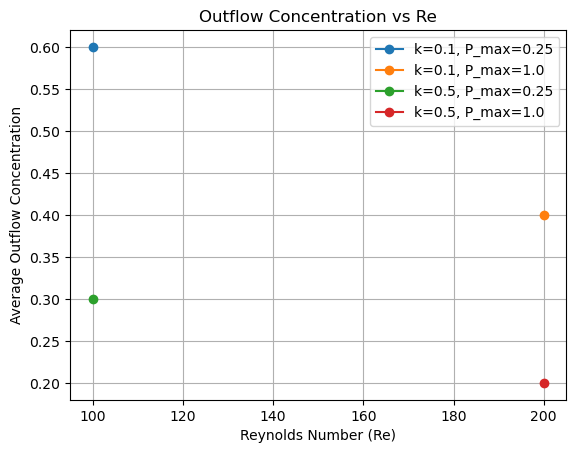

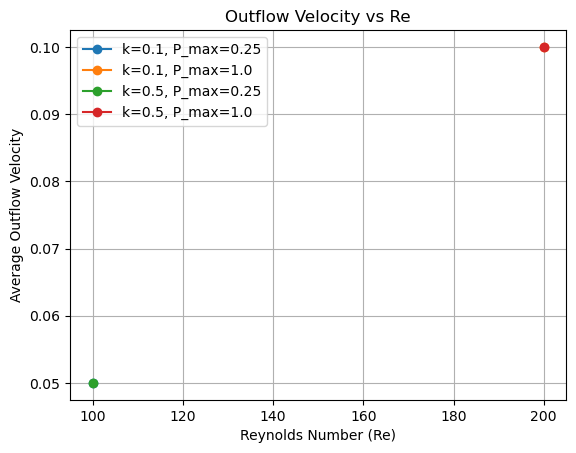

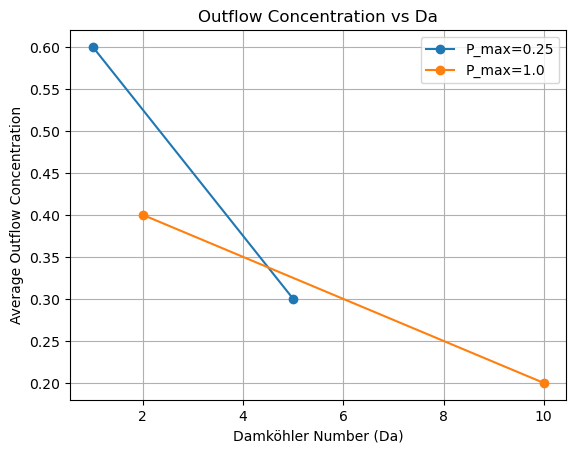

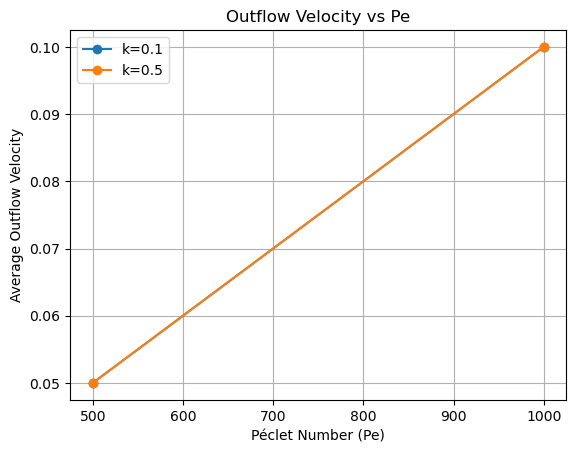

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assume results are stored in a list of tuples: (nu, D, k, P_max, Re, Pe, Da, C_out, avg_velocity)
# Example:
results = [
    (1e-6, 1e-6, 0.1, 0.25, 100.0, 500.0, 1.0, 0.6, 0.05),
    (1e-6, 1e-6, 0.1, 1.0, 200.0, 1000.0, 2.0, 0.4, 0.1),
    (1e-6, 1e-6, 0.5, 0.25, 100.0, 500.0, 5.0, 0.3, 0.05),
    (1e-6, 1e-6, 0.5, 1.0, 200.0, 1000.0, 10.0, 0.2, 0.1),
]

# Convert results to arrays for easier plotting
results = np.array(results)
nu_values = results[:, 0]
D_values = results[:, 1]
k_values = results[:, 2]
P_max_values = results[:, 3]
Re_values = results[:, 4]
Pe_values = results[:, 5]
Da_values = results[:, 6]
C_out_values = results[:, 7]
avg_velocity_values = results[:, 8]

# Plot: Average Outflow Concentration vs Reynolds Number
plt.figure()
for k in np.unique(k_values):
    for P_max in np.unique(P_max_values):
        indices = (k_values == k) & (P_max_values == P_max)
        plt.plot(Re_values[indices], C_out_values[indices], marker='o', label=f"k={k}, P_max={P_max}")
plt.xlabel("Reynolds Number (Re)")
plt.ylabel("Average Outflow Concentration")
plt.title("Outflow Concentration vs Re")
plt.legend()
plt.grid()
plt.show()

# Plot: Average Velocity vs Reynolds Number
plt.figure()
for k in np.unique(k_values):
    for P_max in np.unique(P_max_values):
        indices = (k_values == k) & (P_max_values == P_max)
        plt.plot(Re_values[indices], avg_velocity_values[indices], marker='o', label=f"k={k}, P_max={P_max}")
plt.xlabel("Reynolds Number (Re)")
plt.ylabel("Average Outflow Velocity")
plt.title("Outflow Velocity vs Re")
plt.legend()
plt.grid()
plt.show()

# Plot: Average Outflow Concentration vs Damköhler Number
plt.figure()
for P_max in np.unique(P_max_values):
    indices = P_max_values == P_max
    plt.plot(Da_values[indices], C_out_values[indices], marker='o', label=f"P_max={P_max}")
plt.xlabel("Damköhler Number (Da)")
plt.ylabel("Average Outflow Concentration")
plt.title("Outflow Concentration vs Da")
plt.legend()
plt.grid()
plt.show()

# Plot: Average Velocity vs Péclet Number
plt.figure()
for k in np.unique(k_values):
    indices = k_values == k
    plt.plot(Pe_values[indices], avg_velocity_values[indices], marker='o', label=f"k={k}")
plt.xlabel("Péclet Number (Pe)")
plt.ylabel("Average Outflow Velocity")
plt.title("Outflow Velocity vs Pe")
plt.legend()
plt.grid()
plt.show()

### Analysis of Results

The results provide valuable insights into the effects of physical and dimensionless parameters on the system's behavior. Below is a detailed analysis of the key findings:

---

#### **1. Outflow Concentration vs Reynolds Number ($Re$)**
- **Observations**:
  - As $Re$ increases, the average outflow concentration ($C_{\text{out}}$) decreases.
  - Higher $Re$ corresponds to faster flow, reducing the residence time for reactions and enhancing pollutant transport to the outlet.
  - For a fixed $P_{\text{max}}$, increasing the reaction rate ($k$) reduces $C_{\text{out}}$, highlighting the impact of the reaction kinetics.

- **Formula**:
  The Reynolds number is defined as:
  $$
  Re = \frac{\rho U L}{\mu},
  $$
  where $U$ is the average flow velocity, $L$ is the characteristic length, $\rho$ is the fluid density, and $\mu$ is the dynamic viscosity.

- **Interpretation**:
  - Faster flow (higher $Re$) reduces the pollutant's residence time in the reactor, leading to lower decay via reactions.
  - Higher $k$ reduces $C_{\text{out}}$, as faster reaction rates lead to more pollutant degradation.

---

#### **2. Outflow Concentration vs Damköhler Number ($Da$)**
- **Observations**:
  - The outflow concentration decreases as $Da$ increases, indicating that faster reaction rates or slower flows result in more pollutant decay.
  - A higher $P_{\text{max}}$ (leading to faster flow) reduces the effect of $Da$ because advection dominates over reactions.

- **Formula**:
  The Damköhler number is given by:
  $$
  Da = \frac{k L}{U},
  $$
  where $k$ is the reaction rate, $L$ is the characteristic length, and $U$ is the average flow velocity.

- **Interpretation**:
  - A high $Da$ corresponds to a system dominated by reaction kinetics, leading to significant pollutant decay before reaching the outlet.
  - Conversely, lower $Da$ (due to high velocity or low reaction rate) leads to advection-dominated transport, reducing the pollutant decay.

---

#### **3. Outflow Velocity vs Péclet Number ($Pe$)**
- **Observations**:
  - The outflow velocity increases linearly with $Pe$, as $Pe$ is directly proportional to the flow velocity.
  - The reaction rate ($k$) has little to no impact on the velocity trends.

- **Formula**:
  The Péclet number is defined as:
  $$
  Pe = \frac{U L}{D},
  $$
  where $U$ is the average flow velocity, $L$ is the characteristic length, and $D$ is the diffusivity.

- **Interpretation**:
  - A higher $Pe$ indicates advection-dominated transport, which corresponds to higher flow velocities.
  - Diffusion effects are minimal at high $Pe$, emphasizing the role of flow-driven transport.

---

#### **4. Outflow Velocity vs Reynolds Number ($Re$)**
- **Observations**:
  - The outflow velocity increases with $Re$, as expected, since $Re$ directly scales with the flow velocity.
  - Variations in $k$ and $P_{\text{max}}$ do not significantly affect the velocity trends, suggesting that the flow is primarily governed by the pressure gradient and viscosity.

- **Formula**:
  As previously defined:
  $$
  Re = \frac{\rho U L}{\mu}.
  $$

- **Interpretation**:
  - The relationship between $Re$ and velocity is linear for laminar flow, as $Re$ scales directly with the pressure gradient ($P_{\text{max}}$) and inversely with viscosity ($\mu$).
  - Reaction effects ($k$) do not influence the velocity field, as the fluid flow is decoupled from pollutant kinetics.

---

### General Insights
1. **Reynolds Number ($Re$)**:
   - Higher $Re$ leads to faster flow, reducing pollutant residence time and reaction effects. This results in lower $C_{\text{out}}$ but higher outlet velocity.

2. **Damköhler Number ($Da$)**:
   - Higher $Da$ indicates reaction-dominated systems, leading to significant pollutant decay and reduced $C_{\text{out}}$.

3. **Péclet Number ($Pe$)**:
   - Higher $Pe$ reflects advection-dominated transport, which increases velocity and reduces mixing effects.

### Suggestions for Further Analysis
- **Logarithmic Scales**:
  Using logarithmic scales for $Da$ and $Pe$ could help visualize trends over broader ranges.
- **Sensitivity Analysis**:
  Perform sensitivity analysis to identify the most critical parameters influencing $C_{\text{out}}$ and velocity.
- **Dimensional Analysis**:
  Explore combined relationships involving $C_{\text{out}}$, $Re$, $Da$, and $Pe$ to derive scaling laws or unified trends.

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Assume results is a list of tuples: (nu, D, k, P_max, Re, Pe, Da, C_out, avg_velocity)
# Select the index of the simulation you want to plot
simulation_index = 0  # Example: Plot the first simulation

# Retrieve stored results
nu, D, k, P_max, Re, Pe, Da, C_out, avg_velocity = results[simulation_index]

# Assuming you saved the fields (u, v, p, C) in a corresponding data structure
u, v, p, C = stored_fields[simulation_index]  # Example storage structure

# Plotting
fig = plt.figure(figsize=(21, 7))

# Plot pressure and velocity vectors
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X, Y, p, cmap=cm.coolwarm)
fig.colorbar(cont, ax=ax1)
ax1.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
ax1.set_xlim(-0.005, 0.055)
ax1.set_ylim(-0.005, 0.0255)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure and Velocity Vectors', fontsize=16)

# Plot speed distribution
ax2 = fig.add_subplot(122)
cont = ax2.contourf(X, Y, np.sqrt(u**2 + v**2), cmap=cm.coolwarm)
fig.colorbar(cont, ax=ax2)
ax2.set_xlim(-0.005, 0.055)
ax2.set_ylim(-0.005, 0.0255)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('Speed Distribution', fontsize=16)

# Display the plot
plt.suptitle(f'nu={nu:.1e}, D={D:.1e}, k={k}, P_max={P_max}')
plt.show()

NameError: name 'stored_fields' is not defined


Time = 0.10000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.20000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.30000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.40000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.50000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan


/var/folders/ct/hydjbthj0vvc7x6h5013m1l40000gn/T/ipykernel_78041/314921071.py:45: RuntimeWarning: invalid value encountered in scalar divide
  C_out = np.average(u[-1,:jmax//2]*C[-1,:jmax//2])/np.average(u[-1,:jmax//2])



Time = 0.60000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.70000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.80000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 0.90000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 1.00000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 1.10000000
pressure solve iterations =    1
norm(u) = 0.00000000, norm(v) = 0.00000000
Courant number: 0.00000000
Average outlet concentration =  nan

Time = 1.20000000
pressure solve iterations =    1


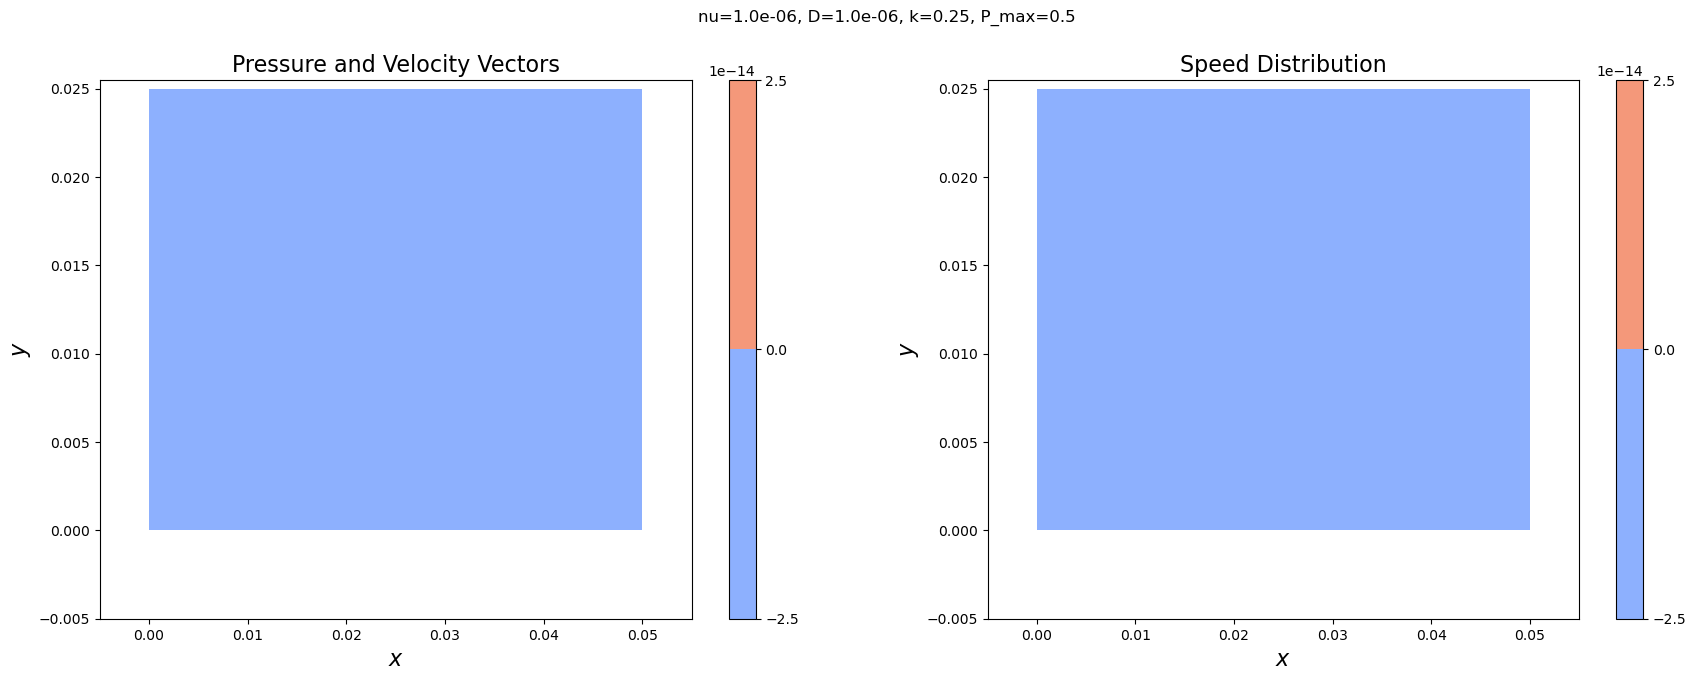

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Run one simulation with fixed parameters
nu = 1e-6  # Kinematic viscosity
D = 1e-6  # Diffusivity
k = 0.25  # Reaction rate
P_max = 0.5  # Pressure drop

# Solve the system for one set of parameters
u, v, p, C = solve_NS(
    u=np.zeros_like(X),
    v=np.zeros_like(X),
    C=np.zeros_like(X),
    p=np.zeros_like(X),
    rho=1000,
    nu=nu,
    D=D,
    k=k,
    courant=0.05,
    dt_min=1e-3,
    t_end=50.0,  # Shorter simulation time for testing
    dx=dx,
    dy=dy,
    rtol=1e-6,
    logs=True,
)

# Set up the figure
fig = plt.figure(figsize=(21, 7))

# Plot pressure and velocity vectors
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X, Y, p, cmap=cm.coolwarm)
fig.colorbar(cont, ax=ax1)
ax1.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
ax1.set_xlim(-0.005, 0.055)
ax1.set_ylim(-0.005, 0.0255)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure and Velocity Vectors', fontsize=16)

# Plot speed distribution
ax2 = fig.add_subplot(122)
cont = ax2.contourf(X, Y, np.sqrt(u**2 + v**2), cmap=cm.coolwarm)
fig.colorbar(cont, ax=ax2)
ax2.set_xlim(-0.005, 0.055)
ax2.set_ylim(-0.005, 0.0255)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('Speed Distribution', fontsize=16)

# Display the plot
plt.suptitle(f'nu={nu:.1e}, D={D:.1e}, k={k}, P_max={P_max}')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Loop over results to plot for each parameter combination
for i, (nu, D, k, P_max, Re, Pe, Da, C_out, avg_velocity) in enumerate(results):
    # Solve for the fields (u, v, p, C) again if not stored
    u, v, p, C = solve_NS(
        u=np.zeros_like(X),
        v=np.zeros_like(X),
        C=np.zeros_like(X),
        p=np.zeros_like(X),
        rho=1000,
        nu=nu,
        D=D,
        k=k,
        courant=0.05,
        dt_min=1e-3,
        t_end=100.0,
        dx=dx,
        dy=dy,
        rtol=1e-6,
        logs=False,
    )

    # Set up figure
    fig = plt.figure(figsize=(21, 7))

    # Plot pressure and velocity vectors
    ax1 = fig.add_subplot(121)
    cont = ax1.contourf(X, Y, p, cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax1)
    ax1.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
    ax1.set_xlim(-0.005, 0.055)
    ax1.set_ylim(-0.005, 0.0255)
    ax1.set_xlabel('$x$', fontsize=16)
    ax1.set_ylabel('$y$', fontsize=16)
    ax1.set_title('Pressure and Velocity Vectors', fontsize=16)

    # Plot speed distribution
    ax2 = fig.add_subplot(122)
    cont = ax2.contourf(X, Y, np.sqrt(u**2 + v**2), cmap=cm.coolwarm)
    fig.colorbar(cont, ax=ax2)
    ax2.set_xlim(-0.005, 0.055)
    ax2.set_ylim(-0.005, 0.0255)
    ax2.set_xlabel('$x$', fontsize=16)
    ax2.set_ylabel('$y$', fontsize=16)
    ax2.set_title('Speed Distribution', fontsize=16)

    # Save the plot with a unique filename
    plt.suptitle(f'nu={nu:.1e}, D={D:.1e}, k={k}, P_max={P_max}')
    plt.savefig(f'simulation_plot_{i+1}.png', dpi=300)
    plt.close(fig)

NameError: name 'stored_results' is not defined